In [1]:
# YOU MUST COPY AND RUN THE FIRST FOUR CELLS FOR THE DATA TO BE CORRECT!!! DON'T FORGET TO DO THAT.

In [2]:
# relevant imports

# base
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# data prep
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from scipy import stats

# nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, average_precision_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss, precision_recall_curve
# !pip install seaborn
import seaborn as sn
import pandas as pd

# import matplotlib
import matplotlib.pyplot as plt

# uncomment !pip install commands if you get an error

In [3]:
# import feature data - make sure csv files are in the same directory
x_train = pd.read_csv("./x_train.csv")
x_val = pd.read_csv("./x_val.csv")

In [78]:
# import state data => no header, so you have to specify header=None
y_name = ["state"]
y_train = pd.read_csv("./y_train.csv", names=y_name, header=None)
y_val = pd.read_csv("./y_val.csv", names=y_name, header=None)

In [5]:
y_train['state'] = y_train['state'].astype('category')
y_val['state'] = y_val['state'].astype('category')

In [80]:
# flatten 1-column dataframe into series
y_train = y_train['state']
y_val = y_val['state']

In [79]:
def binary_encode(state):
    if state == 'successful': return 1
    else: return 0

y_train['state'] = [binary_encode(state) for state in y_train['state']]
y_val['state'] = [binary_encode(state) for state in y_val['state']]

In [7]:
# START OF MY RANDOM FOREST MODEL

In [81]:
# load scikit's random forest classifier library, initialize, and fit model with training data
# https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/
# http://dataaspirant.com/2017/06/26/random-forest-classifier-python-scikit-learn/
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=1000, min_samples_split=10, min_samples_leaf=4, criterion='entropy')
# clf.fit(x_train, y_train)

In [82]:
# clf.get_params()
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [46]:
# RANDOM SEARCH HYPERPARAMETER TUNING
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
# clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = 2)
# Fit the random search model
# clf_random.fit(x_train, y_train)

In [83]:
# predictions and probabilities
predictions = clf.predict(x_val)
probabilities = clf.predict_proba(x_val)
training_predictions = clf.predict(x_train)

In [72]:
# importance of each feature
# list(zip(x_train, clf.feature_importances_))

In [73]:
# CLASSIFICATION METRICS
# https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
# https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428

In [84]:
# training and validation accuracy
print ("Training Accuracy: ", accuracy_score(y_train, training_predictions))
print ("Validation Accuracy: ", accuracy_score(y_val, predictions))
# training and validation balanced accuracy
print ("Training Balanced Accuracy: ", balanced_accuracy_score(y_train, training_predictions))
print ("Validation Balanced Accuracy: ", balanced_accuracy_score(y_val, predictions))

Training Accuracy:  0.7370367578704052
Validation Accuracy:  0.6834401145699857
Training Balanced Accuracy:  0.7054138717500245
Validation Balanced Accuracy:  0.6473542857543556


In [85]:
# confusion matrix basic stats
cm = confusion_matrix(y_val, predictions)
print("Confusion matrix")
print(cm)
# better confusion matrix depiction
pd.crosstab(y_val, predictions, rownames=['Actual Status'], colnames=['Predicted Status'])

Confusion matrix
[[32997  6624]
 [14375 12339]]


Predicted Status,0,1
Actual Status,,
0,32997,6624
1,14375,12339


Text(0.5,1,'Confusion Matrix - Random Forest Classifier v2')

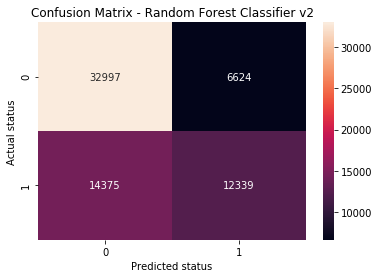

In [86]:
# best confusion matrix depiction using seaborn heatmap
class_names = y_val.unique()
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
fig = plt.figure()
heatmap = sn.heatmap(df_cm, annot=True, fmt="d")
plt.xlabel('Predicted status')
plt.ylabel('Actual status')
plt.title('Confusion Matrix - Random Forest Classifier v2')

In [87]:
# classification report with relevant statistics
cr = classification_report(y_val, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.83      0.76     39621
           1       0.65      0.46      0.54     26714

   micro avg       0.68      0.68      0.68     66335
   macro avg       0.67      0.65      0.65     66335
weighted avg       0.68      0.68      0.67     66335



In [88]:
print("Log loss: ", log_loss(y_val, probabilities))
# get probabilities for the positive class (second column in probabilities)
positive_probabilities = probabilities[:,1]
# is over 0.5 - which is the standard for a no-skill model
print("ROC_AUC score: ", roc_auc_score(y_val.cat.codes, positive_probabilities))

Log loss:  0.5871902867525071


AttributeError: Can only use .cat accessor with a 'category' dtype

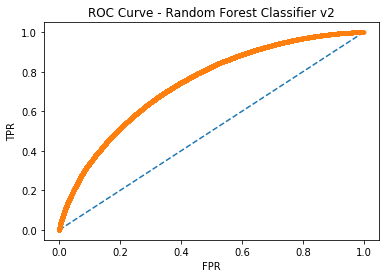

In [61]:
# our dataset is balanced - this one is better
# plot ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
fpr, tpr, thresholds = roc_curve(y_val.cat.codes, positive_probabilities, pos_label=1)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve - Random Forest Classifier v2")
plt.xlabel("FPR")
plt.ylabel("TPR")
# show the plot
plt.show()

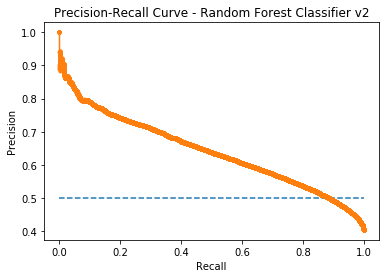

In [56]:
# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val.cat.codes, positive_probabilities)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve - Random Forest Classifier v2")
plt.xlabel("Recall")
plt.ylabel("Precision")
# show the plot
plt.show()

In [57]:
# using only these four features
# feats = ['usd_goal_real','duration_days','goal*days','name_sentiment']
# clf.fit(x_train[feats], y_train)
# predictions and probabilities
# predictions = clf.predict(x_val[feats])
# probabilities = clf.predict_proba(x_val[feats])
# training and validation accuracy
# print ("Train Accuracy: ", accuracy_score(y_train, clf.predict(x_train[feats])))
# print ("Validation Accuracy: ", accuracy_score(y_val, predictions))